In [1]:
# import os, re, sys, IPython, pickle
# from scipy.stats.distributions import norm
# import scipy.special as sc

import bionetgen as pybng
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sbrn
from scipy.optimize import minimize
from scipy.stats.distributions import uniform
from sklearn.linear_model import LinearRegression

/home/boltzmann/apps/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
# Load model object
model = pybng.bngmodel("SIR.bngl")
# this gets you a libRoadRunner simulator
sim = model.setup_simulator().simulator
# this sets the observable names for the libroadrunner simulator
selections = ["time"] + [obs for obs in model.observables]
sim.timeCourseSelections = selections

BioNetGen version 2.6.0
Reading from file temp.bngl (level 0)
Read 6 parameters.
Read 3 molecule types.
Read 3 species.
Read 3 observable(s).
Read 2 reaction rule(s).
ACTION: generate_network( temp )
Iteration   0:     3 species      0 rxns  0.00e+00 CPU s
Iteration   1:     3 species      2 rxns  0.00e+00 CPU s
Cumulative CPU time for each rule
Rule   1:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Rule   2:     1 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Total   :     2 reactions 0.00e+00 CPU s 0.00e+00 CPU s/rxn
Wrote network in net format to ./temp.net.
CPU TIME: generate_network 0.00 s.
Wrote SBML to ./temp_sbml.xml.
CPU TIME: writeSBML 0.00 s.
Finished processing file temp.bngl.
CPU TIME: total 0.03 s.


In [3]:
# Original parameter values 
pnames = [i for i in model.parameters]
for pname in pnames:
    print("{} = {:.3g}".format(pname, getattr(sim, pname)))

N = 100
I0 = 1
R0 = 2.5
g = 0.33
b = 0.00825
_InitialConc1 = 99


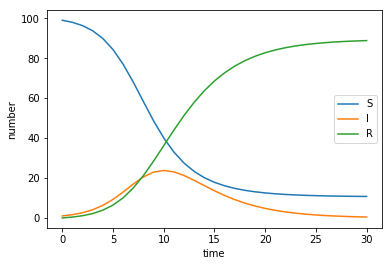

In [4]:
# Run a test simulation and plot
sim.reset()
res = sim.simulate(0, 30, 31)

plt.plot(res['time'],res['S'], label="S")
plt.plot(res['time'],res['I'], label="I")
plt.plot(res['time'],res['R'], label="R")
_ = plt.xlabel('time')
_ = plt.legend()
_ = plt.ylabel('number')

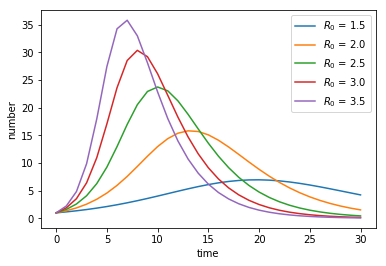

In [5]:
# simple parameter scan
for i in np.arange(1.5,4.0,0.5):
    sim.R0 = np.float(i)
    sim.reset()
    res = sim.simulate(0, 30, 31)
    plt.plot(res['time'], res["I"], label=f"$R_{0}$ = {i}")
plt.legend()
plt.xlabel('time')
_ = plt.ylabel('number')

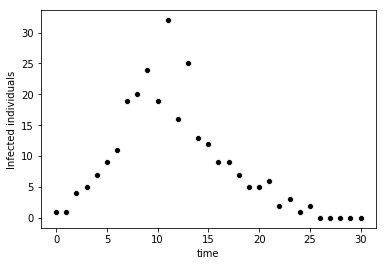

In [6]:
# Run a test simulation and plot
sim.resetAll()
res = sim.simulate(0, 30, 31)

# construct and save synthetic data set for I(t)
m_time = res['time']
m_I = res['I']
m_I += np.random.normal(loc=0,scale=0.3*m_I,size=len(m_I))
m_I = np.floor(m_I)
m_I[0] = sim.I0

# convert infected data to integer and add noise
d = {'time': m_time, 'I': m_I}
exp = pd.DataFrame(data=d)

# Plot original result and result of adding noise
sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = plt.ylabel('Infected individuals')

In [7]:
def cost(params, weights=[]):
    sim.R0 = params[0]
    sim.g = params[1]
    sim.reset() # Updates the dependent parameters
    #print([model.R0, model.g,model.b])
    res_c = sim.simulate(0, 30, 31)
    # initialize weights if not given
    if (len(weights)==0):
        weights= np.array([1.0/np.sqrt(7) for i in range(31)])
    y_diff = exp['I'] - res_c['I']
    return (sum((y_diff*weights)**2))

cost =  884.5929760233097


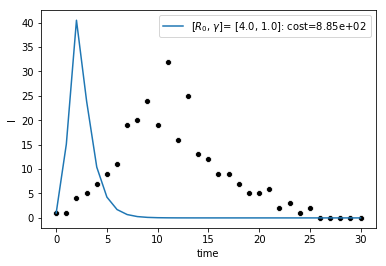

In [8]:
# Show starting cost function value and fit
p0=[4,1]
print("cost = ",cost(p0))
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label=r'[$R_0$, $\gamma$]= [4.0, 1.0]: cost={:0.2e}'.format(cost(p0)))

In [9]:
minimized = minimize(cost, x0=[10,0.1], method='nelder-mead',options={'maxiter':1000})
print(minimized)

 final_simplex: (array([[2.51514113, 0.3307751 ],
       [2.51505317, 0.33078605],
       [2.51504232, 0.33079418]]), array([29.96527797, 29.96527828, 29.96527957]))
           fun: 29.965277970383905
       message: 'Optimization terminated successfully.'
          nfev: 206
           nit: 108
        status: 0
       success: True
             x: array([2.51514113, 0.3307751 ])


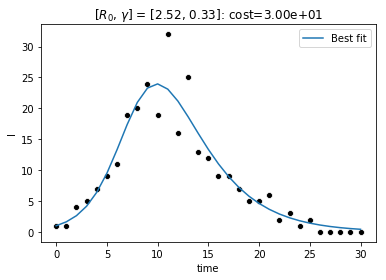

In [10]:
# Show final cost function value and fit
p_final= minimized.x
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(x=exp.time, y=exp.I,color='black')
_ = sbrn.lineplot(x=res['time'], y=res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

In [11]:
minimized_bfgs = minimize(cost, x0=[4,1], method='BFGS')
print(minimized_bfgs)

      fun: 29.965277721455983
 hess_inv: array([[3.47302690e-05, 2.29925500e-05],
       [2.29925500e-05, 2.41802264e-05]])
      jac: array([0.00018668, 0.00051761])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 359
      nit: 18
     njev: 116
   status: 2
  success: False
        x: array([2.51510596, 0.33077889])


cost =  29.965277721455983
x= [2.51510596 0.33077889]


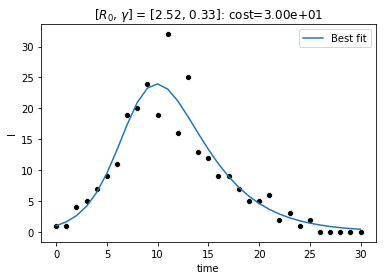

In [12]:
# Show final cost function value and fit
p_final= minimized_bfgs.x
print("cost = ", cost(p_final))
print('x=',p_final)
sim.reset()
res = sim.simulate(0, 30, 31)
_ = sbrn.scatterplot(exp.time, exp.I,color='black')
_ = sbrn.lineplot(res['time'], res['I'], label="Best fit")
_ = plt.title(r'[$R_0$, $\gamma$] = [{:.2f}, {:.2f}]: cost={:0.2e}'.format(p_final[0], p_final[1], cost(p_final)))

In [13]:
# import sys
# !{sys.executable} -m pip install pyDOE
import pyDOE

In [26]:
sim.resetAll()
# This "names" need to be the names of the varying parameters list
# let's do it on everything
to_scan = ["R0", "g"]
n_dim = len(to_scan)
n_samples = int(1e4)
# Let's implement some latin hypercube here
# Get appropriate number of samples
lhs_samples = pyDOE.lhs(n_dim, samples=n_samples)
# We want to center from where we started
means = [getattr(sim, rate_name) for rate_name in to_scan]
means = np.log10(means)
# and say we want to scan about an order of magnitude
scale = 1
lhs_samples = uniform(loc=-scale, scale=scale*2.0).ppf(lhs_samples)
for i in range(n_dim):
    lhs_samples[:,i] += means[i]
for i in range(n_dim):
    print(f"parameter: {to_scan[i]}, original log(value): {means[i]}")
    print(f"sample min: {lhs_samples[:,i].min()}, sample max: {lhs_samples[:,i].max()}")
    print(f"sample mean: {lhs_samples[:,i].mean()}, sample std: {lhs_samples[:,i].std()}")
lhs_samples = np.power(10,lhs_samples)

parameter: R0, original log(value): 0.3979400086720376
sample min: -0.6020278084947108, sample max: 1.3978298589065754
sample mean: 0.3979401655595829, sample std: 0.5773507938284447
parameter: g, original log(value): -0.4814860601221125
sample min: -1.4814817396095772, sample max: 0.5184364635965117
sample mean: -0.4814867361470946, sample std: 0.5773505023952891


In [29]:
def simulate_param(simulator, parameters):
    for pind, pname in enumerate(to_scan):
        simulator.setGlobalParameterByName(pname, np.power(10, parameters[pind]))
    simulator.reset()
    res_c = sim.simulate(0, 30, 31)
    return res_c

def get_obs(result):
    return result["I"][-1]

In [30]:
results = []
observables = []
samples = []

for sample in lhs_samples:
    try:
        res = simulate_param(sim, sample)
    except RuntimeError:
        continue
    samples.append(sample)
    results.append(res)
    observables.append(get_obs(res))

results = np.array(results)
observables = np.array(observables)
samples = np.array(samples)
print(f"{len(results)} samples successfuly simulated")

7645 samples successfuly simulated


fit score 0.7626208888760385
R0 coefficient: -0.2252855501641393, g coefficient: -4.196658612606835


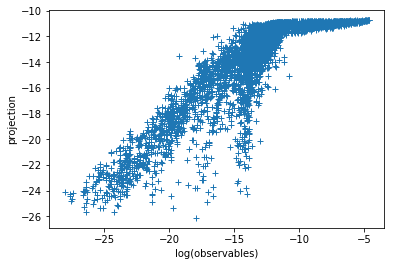

In [31]:
# make sure to remove any negative values
inds_to_use = observables > 0
observables = observables[inds_to_use]
obs = np.log10(observables)
samples = samples[inds_to_use]

reg = LinearRegression().fit(samples,obs)
proj = reg.predict(samples)
score = reg.score(samples, obs)
print(f"fit score {score}")
print(f"R0 coefficient: {reg.coef_[0]}, g coefficient: {reg.coef_[1]}")

# plot
plt.plot(obs, proj, lw=0, marker="+")
plt.xlabel("log(observables)")
_ = plt.ylabel("projection")

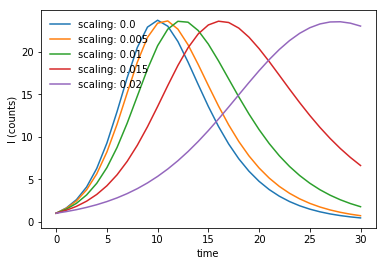

In [32]:
sim.resetAll()

scaling_obs = []
for lam in np.linspace(0, 0.02, num=5):
    for iparam, pname in enumerate(to_scan):
        cval = sim.getGlobalParameterByName(pname)
        sim.setGlobalParameterByName(pname, cval+(lam*reg.coef_[iparam]))
    sim.reset()
    res = sim.simulate(0,30,31)
    scaling_obs.append(get_obs(res))
    plt.plot(res["time"], res["I"], label=f"scaling: {lam}")
plt.xlabel("time")
plt.ylabel("I (counts)")
_ = plt.legend(frameon=False)

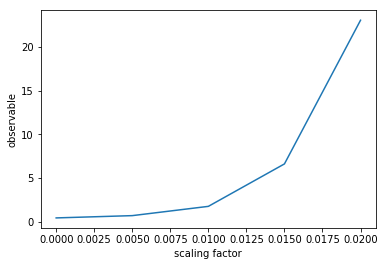

In [33]:
plt.plot(np.linspace(0, 0.02, num=5), scaling_obs)
plt.xlabel("scaling factor")
_ = plt.ylabel("observable")